<a href="https://colab.research.google.com/github/theviderlab/computer_vision/blob/main/Faster_R_CNN_con_Detectron2_Backbone_CVNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Paso 1: Instalar Detectron2
!pip install -q torch torchvision torchaudio
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-qpeu3xe1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-qpeu3xe1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
base_path = "/content/drive/MyDrive/ViderLab/06 - INFORMACIÓN/Capacitación/Master/TFM/Código/"
cvnet_path = base_path + "image_retrieval/backbones/"

In [4]:
import sys
sys.path.append(cvnet_path)

In [5]:
from cvnet.cvnet_model import CVNet_Rerank

In [6]:
import torch.nn as nn
from collections import OrderedDict
from detectron2.layers import ShapeSpec
from detectron2.modeling.backbone import Backbone

class CVNetBottomUp(Backbone):
    def __init__(self, cvnet):
        super().__init__()
        self.cvnet = cvnet  # instancia de CVNet_Rerank con pesos cargados

    def forward(self, x):
        return self.cvnet.extract_backbone_stages(x)

    def output_shape(self):
        return {
            "res2": ShapeSpec(channels=256, stride=4),
            "res3": ShapeSpec(channels=512, stride=8),
            "res4": ShapeSpec(channels=1024, stride=16),
            "res5": ShapeSpec(channels=2048, stride=32),
        }

In [7]:
from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file
from detectron2.checkpoint import DetectionCheckpointer

# Config base
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# Desactivar preentrenado de resnet para evitar conflictos
cfg.MODEL.RESNETS.DEPTH = 50  # Solo para mantener consistencia
cfg.MODEL.WEIGHTS = ""  # No cargar pesos predefinidos

# Crear instancia CVNet_Rerank y cargar pesos
cvnet = CVNet_Rerank(RESNET_DEPTH=50, REDUCTION_DIM=256)
# cvnet.load_state_dict(torch.load(...))  # si tenés pesos

# Instanciar wrapper compatible
cvnet_backbone = CVNetBottomUp(cvnet)

# Construir FPN con este backbone
from detectron2.modeling.backbone.fpn import FPN, LastLevelMaxPool

backbone = FPN(
    bottom_up=cvnet_backbone,
    in_features=["res2", "res3", "res4", "res5"],
    out_channels=256,
    top_block=LastLevelMaxPool(),
    fuse_type="sum"
)

# Reemplazar en el modelo
cfg.MODEL.BACKBONE.FREEZE_AT = 0  # opcional
model = build_model(cfg)
model.backbone = backbone
model.eval()  # por ahora solo inferencia

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): CVNetBottomUp(
      (cvnet): CVNet_Rerank(
        (encoder_q): ResNet(
          (stem): ResStemIN(
            (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [8]:
database_path = base_path + "assets/database/datasets/rparis6k"
image_root_dir = database_path + "/jpg/"

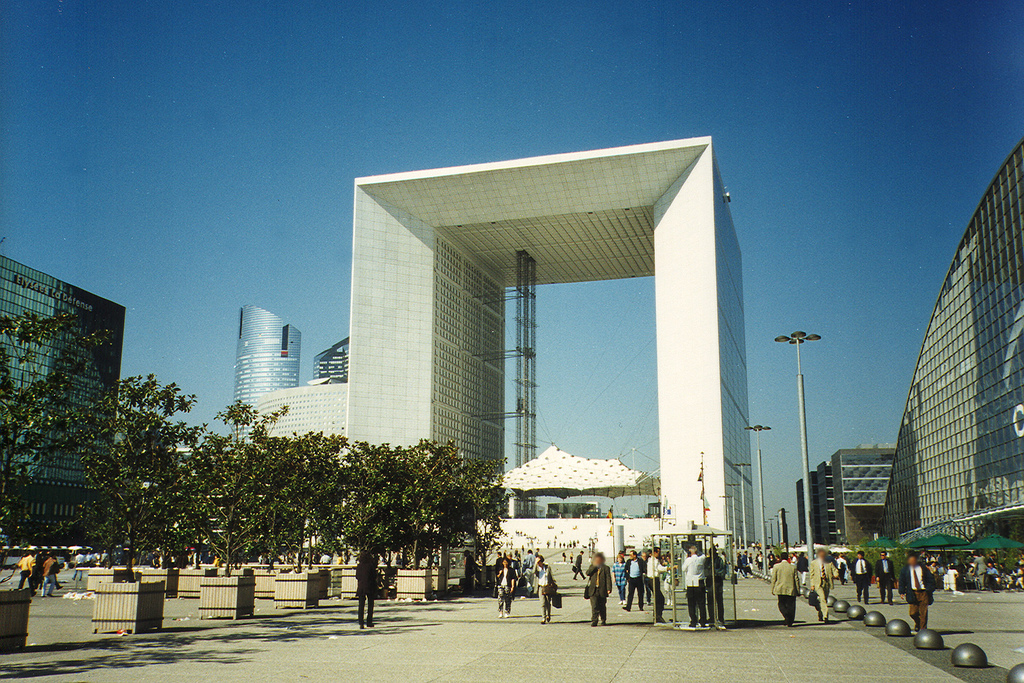

In [9]:
import cv2
from google.colab.patches import cv2_imshow

# 2. Cargar una imagen de prueba
test_image_path = image_root_dir+"/paris_defense_000176.jpg"
image = cv2.imread(test_image_path)
cv2_imshow(image)

In [10]:
from detectron2.structures import Instances, ImageList
import torch

img_tensor = torch.as_tensor(image.transpose(2, 0, 1)).float().unsqueeze(0).cuda()
img_tensor /= 255.0  # Normalización simple, ajustá según tus necesidades


cvnet = cvnet.to("cuda")
model = model.to("cuda")
img_tensor = img_tensor.cuda()

inputs = [{"image": img_tensor[0], "height": image.shape[0], "width": image.shape[1]}]

with torch.no_grad():
    outputs = model(inputs)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


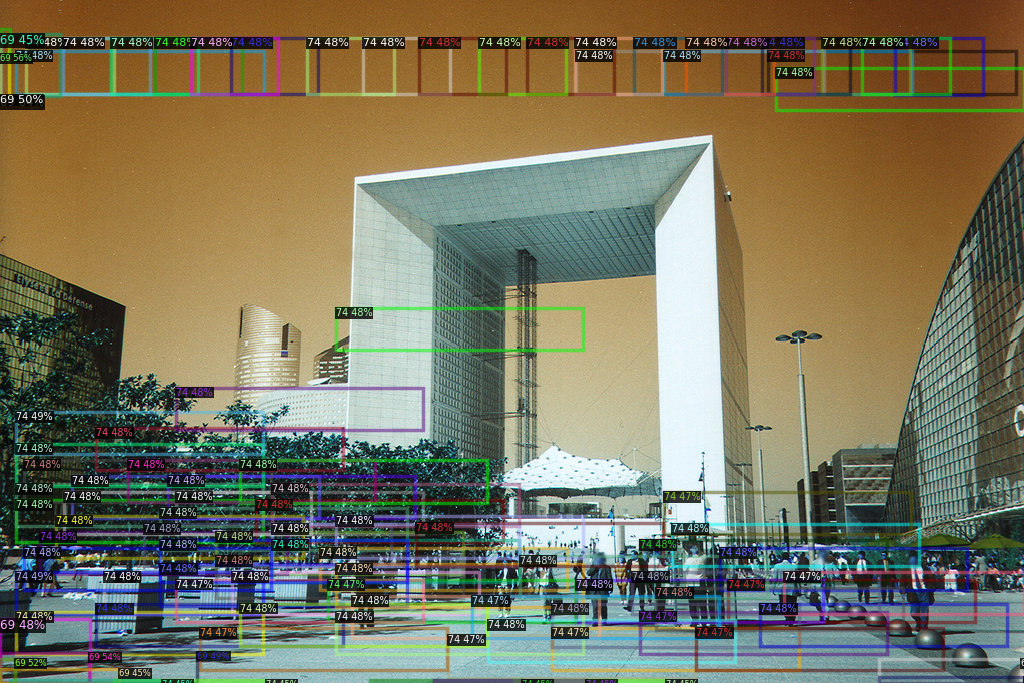

In [12]:
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

# Convertir imagen a formato BGR uint8 (Detectron2 usa OpenCV)
image_bgr = (img_tensor[0].permute(1, 2, 0).cpu().numpy() * 255).astype("uint8")
image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR)

# Obtener predicciones del modelo
instances = outputs[0]["instances"].to("cpu")

# Si no registraste tu dataset, usá un MetadataCatalog vacío
metadata = MetadataCatalog.get("__unused")  # nombre cualquiera

# Visualizar
v = Visualizer(image_bgr[:, :, ::-1], metadata=metadata, scale=1.0)
out = v.draw_instance_predictions(instances)
cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
# Visualizar feature maps
with torch.no_grad():
    feature_maps = model.backbone.bottom_up(img_tensor)

for name, fmap in feature_maps.items():
    print(f"{name}: shape={fmap.shape}, min={fmap.min().item():.4f}, max={fmap.max().item():.4f}, mean={fmap.mean().item():.4f}")

res2: shape=torch.Size([1, 256, 171, 256]), min=-0.0497, max=0.7102, mean=0.0597
res3: shape=torch.Size([1, 512, 86, 128]), min=-0.0204, max=0.3440, mean=0.0251
res4: shape=torch.Size([1, 1024, 43, 64]), min=-0.0077, max=0.1734, mean=0.0105
res5: shape=torch.Size([1, 2048, 22, 32]), min=-0.0041, max=0.0733, mean=0.0042


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def display_featuremap_overlay_grid(image_rgb, feature_maps, intensity=0.4):
    """
    Muestra una grilla con la imagen original, el heatmap del feature map
    y la superposición para cada stage de un backbone.

    Args:
        image_rgb (np.array): Imagen RGB (H, W, 3) original.
        feature_maps (dict): Diccionario con features de cada stage.
        intensity (float): Intensidad del overlay (entre 0 y 1).
    """
    stages = list(feature_maps.keys())
    n_stages = len(stages)
    fig, axes = plt.subplots(n_stages, 3, figsize=(15, 5 * n_stages))

    if n_stages == 1:
        axes = [axes]  # compatibilidad con una sola fila

    for i, stage in enumerate(stages):
        fmap = feature_maps[stage][0].cpu().numpy()  # (C, H, W)

        # Promediar canales para obtener mapa de calor
        heatmap = np.mean(fmap, axis=0)
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / (np.max(heatmap) + 1e-8)  # normalización

        # Resize a tamaño original
        heatmap_resized = cv2.resize(heatmap, (image_rgb.shape[1], image_rgb.shape[0]))
        heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_rgb = cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB)

        # Overlay con la imagen original
        overlay = (1 - intensity) * image_rgb + intensity * heatmap_rgb
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)

        # Mostrar
        axes[i][0].imshow(image_rgb)
        axes[i][0].set_title(f"Original - {stage}")
        axes[i][0].axis("off")

        axes[i][1].imshow(heatmap_rgb)
        axes[i][1].set_title(f"Mapa de Calor - {stage}")
        axes[i][1].axis("off")

        axes[i][2].imshow(overlay)
        axes[i][2].set_title(f"Superposición - {stage}")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()

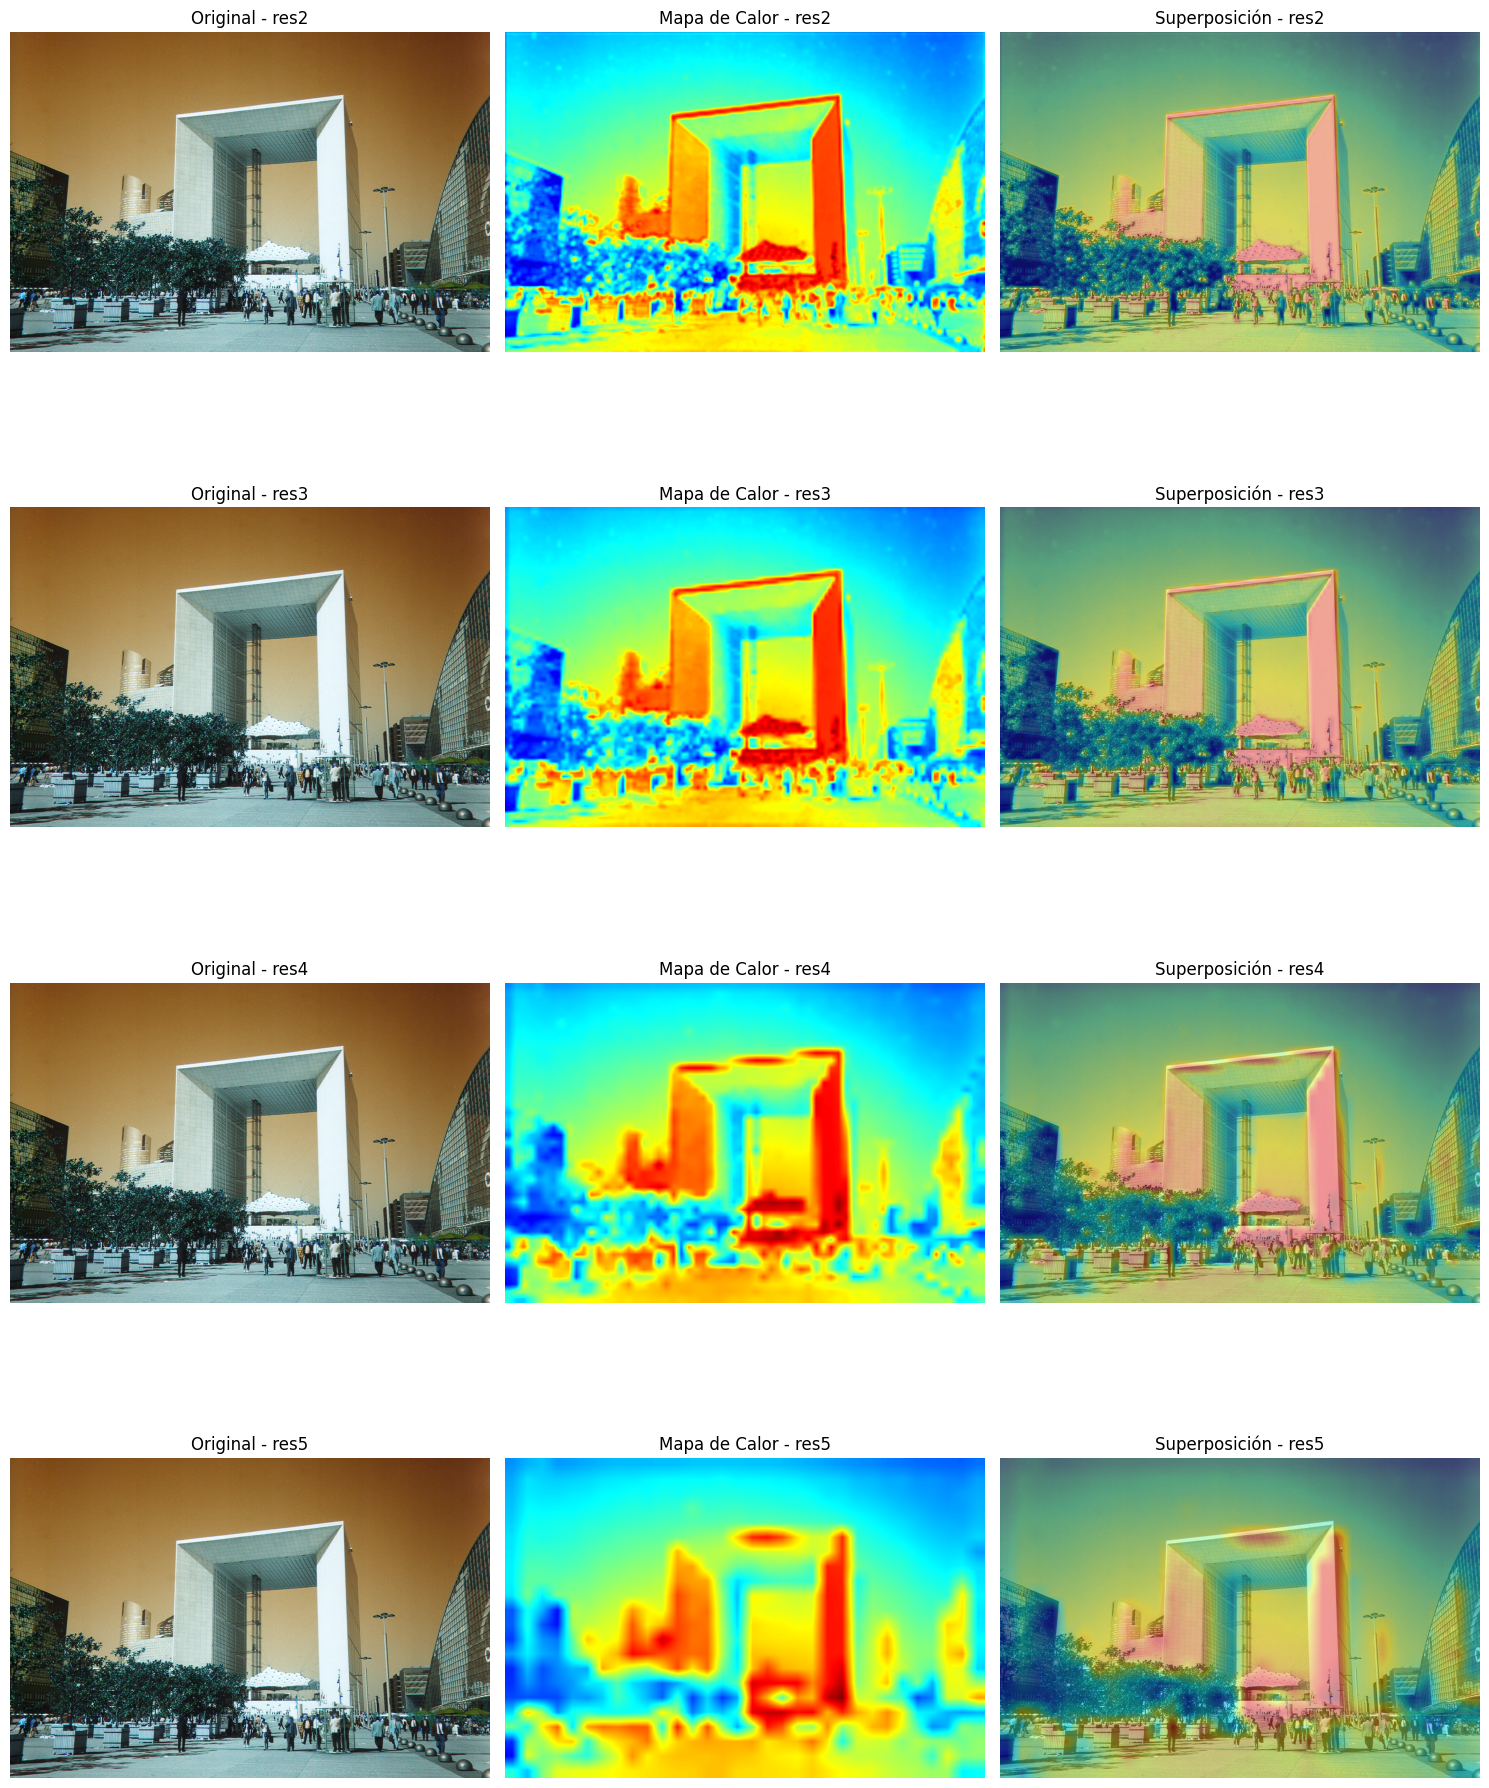

In [17]:
image_rgb = (img_tensor[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
display_featuremap_overlay_grid(image_rgb, feature_maps, intensity=0.4)